In [60]:
#import necessary packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import necessary modules that are included into the function
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut,ShuffleSplit
import itertools 
import matplotlib.pyplot as plt
from math import log
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import re
import sys
import os

# #files
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [66]:

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..\..\..'))
sys.path.append(parent_dir)

import config_03


# Resolve the absolute path of the dataset
global_dataset_dir = os.path.abspath(os.path.join(parent_dir, config_03.dataset["globaldataset"]))
print(global_dataset_dir)

dataset = pd.read_csv(global_dataset_dir, sep=';')

pd.set_option('display.max_columns', None)
#examine
dataset.describe()


config_03 imported successfully.
c:\Users\foeke\OneDrive\Documenten\github\A-close-look-at-using-national-ground-stations-for-the-statistical-mapping-ofNO2\data\input\GlobalModelData\ModellingDataset-Global.csv


,FID,Longitude,Latitude,wkd_day_value,wnd_day_value,wkd_night_value,wnd_night_value,mean_value_NO2,radiation,nightlight_450,nightlight_4950,nightlight_3150,nightlight_900,elevation,industry_1000,industry_100,industry_25,industry_3000,industry_300,industry_5000,industry_500,industry_50,population_1000,population_3000,population_5000,road_class_1_1000,road_class_1_100,road_class_1_25,road_class_1_3000,road_class_1_300,road_class_1_5000,road_class_1_500,road_class_1_50,road_class_2_1000,road_class_2_100,road_class_2_25,road_class_2_3000,road_class_2_300,road_class_2_5000,road_class_2_500,road_class_2_50,road_class_3_1000,road_class_3_100,road_class_3_25,road_class_3_3000,road_class_3_300,road_class_3_5000,road_class_3_500,road_class_3_50,temperature_2m_10,temperature_2m_11,temperature_2m_12,temperature_2m_1,temperature_2m_2,temperature_2m_3,temperature_2m_4,temperature_2m_5,temperature_2m_6,temperature_2m_7,temperature_2m_8,temperature_2m_9,TROP_2018,wind_speed_10m_10,wind_speed_10m_11,wind_speed_10m_12,wind_speed_10m_1,wind_speed_10m_2,wind_speed_10m_3,wind_speed_10m_4,wind_speed_10m_5,wind_speed_10m_6,wind_speed_10m_7,wind_speed_10m_8,wind_speed_10m_9,trop_mean_filt_2019,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,BldDen100,BldDen500,BldDen1000,NDVI,trafBuf25,trafBuf50,trafBuf100,trafBuf400,trafBuf800
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02,482.000000,482.000000,4.820000e+02,482.000000,4.820000e+02,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,481.000000,481.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,476.000000,482.000000,482.000000,482.000000,482.000000,482.000000
mean,240.500000,9.261343,51.197532,26.954116,19.891472,21.943770,19.482789,23.704356,2.958882,15.339811,9.044924,11.042987,14.757297,171.712392,1.759829e+05,1379.668050,141.338174,1.627321e+06,12540.197095,3.855807e+06,37978.475104,357.883817,6154.486286,41489.437120,94125.623430,1212.001476,12.295357,1.529753,12302.269079,101.676785,34352.880077,280.871975,3.874495,2231.118530,68.942846,14.572097,12916.796713,330.254867,26376.055502,732.897073,28.610143,22133.352695,272.058826,32.639911,136692.065999,2314.033584,304244.123667,6247.359697,79.579393,11.888703,5.707740,3.065015,-1.388283,3.377644,7.307135,7.759075,14.236675,18.137460,18.359029,18.242144,13.458786,447.853711,3.617826,3.077223,3.656993,2.804031,3.360133,3.193947,2.921907,2.538312,2.970147,2.658043,2.482413,2.674618,0.000067,44.110073,48.822715,54.784274,32.894402,52.052772,79.125816,123.538727,79.417375,77.112976,69.232866,81.436638,83.921225,0.677052,0.622411,0.571960,3331.373950,128.701763,146.889530,199.251786,417.690278,587.171424
std,139.285678,2.738530,1.621991,16.037734,12.152807,9.692638,8.988529,12.886250,0.135886,13.528546,10.100697,10.940724,12.881364,210.376782,3.420002e+05,5266.517329,595.285466,1.873091e+06,36913.058761,3.917068e+06,95029.695119,1491.693070,4509.973126,34979.658532,88294.089372,2705.754172,73.109976,12.240787,13434.904611,403.926782,30123.308469,911.739711,28.728664,2656.942121,145.932769,34.954581,11587.403831,545.379983,20947.147222,1087.161665,64.267149,13329.888215,236.379343,41.931537,83339.859648,1547.899665,186246.744040,3891.777537,86.872853,1.606676,1.440989,1.549856,2.140847,1

### store geodata

In [67]:
#assign current dataset, including information on x and y to variable "dataset_xy"
dataset_xy = dataset

## Data processing

In [68]:
#get rid off unnecessary variables

#unique identifier and geodata
dataset = dataset.drop(['Longitude', 'Latitude'], axis=1)
#also drop temporal NO2 variables
dataset = dataset.drop(['FID', 'wkd_day_value', 'wnd_day_value', 'wkd_night_value', 'wnd_night_value'], axis=1)
#replace NA with 0
dataset=dataset.fillna(0)
print(len(dataset.columns))

## == CREATE DEPENDENT- AND INDEPENDENT VARIABLES == ##

#store all column names
all_column_names = dataset.columns
#create dataset with only predictor variables
x = dataset.drop(["mean_value_NO2"], axis=1)
#store column names of predictor variables
feature_names = x.columns
#dependent variable
y = dataset["mean_value_NO2"]
#verify if dependent variable is out of dataset
print(len(feature_names))

89
88


In [ ]:
#transform dependent- and independent variables to numpy arrays for calculations
x = np.array(x)
y = np.array(y)

In [70]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..\..\..'))
sys.path.append(parent_dir)

print(parent_dir)


# Resolve the absolute path of the dataset
medianshap_dataset_dir = os.path.abspath(os.path.join(parent_dir, config_03.dataset['medianshapcv10']))
print(medianshap_dataset_dir)


c:\Users\foeke\OneDrive\Documenten\github\A-close-look-at-using-national-ground-stations-for-the-statistical-mapping-ofNO2
c:\Users\foeke\OneDrive\Documenten\github\A-close-look-at-using-national-ground-stations-for-the-statistical-mapping-ofNO2\data\input\GlobalModelData\df median shap cv10.csv


In [71]:
medianshap_dataset = pd.read_csv(medianshap_dataset_dir, sep = ',')

In [ ]:
medianshap_dataset.head(10)

,Unnamed: 0,name,rank,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,median
0,0,population_3000,1,1,2,1,1,1,2,2,1,2,1.0
1,2,road_class_3_3000,3,2,1,4,5,2,1,3,7,1,2.5
2,1,trafBuf25,2,3,3,3,4,5,5,5,6,3,3.5
3,3,population_1000,4,7,4,2,3,3,4,4,5,7,4.0
4,4,nightlight_450,5,4,19,6,2,10,3,1,3,5,4.5
5,6,nightlight_3150,7,15,7,5,8,4,14,6,20,4,7.0
6,8,trafBuf50,9,5,5,16,20,8,6,7,2,10,7.5
7,10,road_class_3_300,11,8,17,8,22,6,10,9,4,8,8.5
8,7,BldDen100,8,12,6,7,7,17,11,14,10,6,9.0
9,12,NDVI,13,11,10,9,12,18,9,16,23,17,12.5


In [ ]:
#CONSTRUCT FUNCTION - CV AIC-MSE-R2

from sklearn.metrics import r2_score


#set initial model
model = RandomForestRegressor(n_estimators = 1000, random_state = 42, min_samples_split=10,
                          min_samples_leaf=5,max_features="sqrt",max_depth=10, bootstrap=True )

#generate function that creates K-fold CV, thereby creating shap summary plot for each loop/fold.

def cvaic(data_x, data_y, model, nofolds, names, novar):
    ss = ShuffleSplit(n_splits=nofolds, test_size=0.25, random_state=0)

    total_msetest = [0]
    total_r2 = [0]
    total_rmse = [0]
   
    
    for train, test in ss.split(data_x, data_y):
        data_x_train = np.array(data_x[train])
        data_y_train = np.array(data_y[train])
        data_x_test = np.array(data_x[test])
        data_y_test = np.array(data_y[test])
        

        num_params = novar + 1 #+1 for intercept
#
        model.fit(data_x_train, data_y_train)

        y_predicted = model.predict(data_x_test) #predict dependent var based on x number of most important ind. var.

        mse_test = mean_squared_error(data_y_test, y_predicted)
        
        r2 = r2_score(data_y_test, y_predicted)
        
        def rmse(predictions, targets):
                return np.sqrt(((predictions - targets) ** 2).mean())
        rmse_val = rmse(y_predicted, data_y_test)

        mse_vals= np.abs(mse_test)

        r2_vals = np.abs(r2)

        rmse_vals = np.abs(rmse_val)

        total_msetest += mse_vals
        total_r2 += r2_vals
        total_rmse += rmse_vals

    cvaic.meanmse = total_msetest/nofolds #allows use of local variable outside function
    cvaic.meanr2 = total_r2/nofolds #allows use of local variable outside function
    cvaic.meanrmse = total_rmse/nofolds #allows use of local variable outside function


## Create list of No. most important predictors

In [ ]:
locals()["Novar"] = []
i=1
novar = range(1,31,1) #30 best predictors are subject to predictor selection
while i < len(novar):
    print(i)
    sorted_vars_names = medianshap_dataset['name'].head(novar[i])

    sorted_vars_names = sorted_vars_names.to_string(index=False)
    names = '|'.join(sorted_vars_names.split())

    print(names)
    locals()["Novar"].append(names)
    i+=1

1
population_3000|road_class_3_3000
2
population_3000|road_class_3_3000|trafBuf25
3
population_3000|road_class_3_3000|trafBuf25|population_1000
4
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450
5
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150
6
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50
7
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300
8
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300|BldDen100
9
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300|BldDen100|NDVI
10
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300|BldDen100|NDVI|road_class_2_25
11
population_3000|road_class_3_3000|trafBuf25

## Rename parts of items to avoid too many predictors selection

In [ ]:

novar2 = [re.sub(r'(?<=BldDen100)|(?<=road_class_3_300)\b|(?<=trafBuf100)\b|(?<=road_class_2_50)\b|(?<=road_class_2_100)\b|(?<=road_class_3_100)\b|(?<=road_class_3_50)\b' , '$', i) for i in Novar]


In [ ]:
len(novar2)

29

## Loop. Aim: to calculate AIC, MSETE, and R2 of each no. of predictors, ranging from 2-30.

In [ ]:
i = 0 #number of independent variables needed


#locals()["CV_AIC"] = []
locals()["CV_MSE"] = []
locals()["CV_R2"] = []
locals()["CV_RMSE"] = []

locals()["Novar"] = []

while i < len(novar2):
    print(novar2[i])
   
    input_dataset = dataset.filter(regex=novar2[i])

    colen = len(input_dataset.columns)
    print(colen)
    best_x = np.array(input_dataset)

    cvaic(best_x, y, model, 10, feature_names, colen) #ind. vars; dep var; specific model; number of folds, amount of vars.

    #CV_aic = cvaic.meanaic
    CV_mse = cvaic.meanmse
    CV_r2 = cvaic.meanr2 
    CV_rmse = cvaic.meanrmse 

    #print(CV_aic)
    print(CV_mse)
    print(CV_r2)
    print(CV_rmse)
    
    #store result to list
    #locals()["CV_AIC"].append(CV_aic)
    locals()["CV_MSE"].append(CV_mse)
    locals()["CV_R2"].append(CV_r2)
    locals()["CV_RMSE"].append(CV_rmse)
    
    locals()["Novar"].append(colen)
    i+=1
    
    

population_3000|road_class_3_3000
2
[74.33245247]
[0.5075678]
[8.6166285]
population_3000|road_class_3_3000|trafBuf25
3
[56.70911931]
[0.62528998]
[7.52451506]
population_3000|road_class_3_3000|trafBuf25|population_1000
4
[57.70380641]
[0.61814318]
[7.59119023]
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450
5
[55.9409683]
[0.62997098]
[7.47284855]
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150
6
[56.40770074]
[0.62730149]
[7.50460944]
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50
7
[54.5082653]
[0.63950226]
[7.37527833]
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300$
8
[52.83020979]
[0.65084022]
[7.26062866]
population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300$|BldDen100$
9
[48.84853569]
[0.67747878]
[6.97968067]
population_300

In [ ]:
# print(CV_AIC)
print(CV_MSE)
print(CV_R2)
print(CV_RMSE)
print(Novar)

[array([74.33245247]), array([56.70911931]), array([57.70380641]), array([55.9409683]), array([56.40770074]), array([54.5082653]), array([52.83020979]), array([48.84853569]), array([48.80801534]), array([47.05152132]), array([44.36163148]), array([44.26890416]), array([44.94157274]), array([43.96980475]), array([43.41167899]), array([43.5628616]), array([44.31851812]), array([44.57408517]), array([44.06603125]), array([43.59794983]), array([43.66247789]), array([43.76365961]), array([42.93080593]), array([42.59928423]), array([42.48391477]), array([42.34360441]), array([42.22830451]), array([42.1593525]), array([41.88345945])]
[array([0.5075678]), array([0.62528998]), array([0.61814318]), array([0.62997098]), array([0.62730149]), array([0.63950226]), array([0.65084022]), array([0.67747878]), array([0.67776118]), array([0.68925062]), array([0.70708637]), array([0.70786945]), array([0.70331062]), array([0.70993756]), array([0.71358367]), array([0.71240643]), array([0.70742115]), array([0

In [ ]:
Novar_performances = pd.DataFrame({
     'Novar': Novar,
#      'CV_AIC': CV_AIC ,
     'CV_MSE': CV_MSE,
     'CV_R2': CV_R2,
     'CV_RMSE' : CV_RMSE
     
    })

In [ ]:
#remove square brackets
# Novar_performances['CV_AIC'] = Novar_performances['CV_AIC'].str[0]
Novar_performances['CV_MSE'] = Novar_performances['CV_MSE'].str[0]
Novar_performances['CV_R2'] = Novar_performances['CV_R2'].str[0]
Novar_performances['CV_RMSE'] = Novar_performances['CV_RMSE'].str[0]

In [ ]:
print(Novar_performances)

    Novar     CV_MSE     CV_R2   CV_RMSE
0       2  74.332452  0.507568  8.616629
1       3  56.709119  0.625290  7.524515
2       4  57.703806  0.618143  7.591190
3       5  55.940968  0.629971  7.472849
4       6  56.407701  0.627301  7.504609
5       7  54.508265  0.639502  7.375278
6       8  52.830210  0.650840  7.260629
7       9  48.848536  0.677479  6.979681
8      10  48.808015  0.677761  6.976816
9      11  47.051521  0.689251  6.851936
10     12  44.361631  0.707086  6.651944
11     13  44.268904  0.707869  6.644354
12     14  44.941573  0.703311  6.694906
13     15  43.969805  0.709938  6.622565
14     16  43.411679  0.713584  6.580929
15     17  43.562862  0.712406  6.593253
16     18  44.318518  0.707421  6.650036
17     19  44.574085  0.705625  6.669561
18     20  44.066031  0.709158  6.630109
19     21  43.597950  0.712284  6.595364
20     22  43.662478  0.711832  6.601110
21     23  43.763660  0.711166  6.608698
22     24  42.930806  0.716815  6.545093
23     25  42.59

In [ ]:
Novar_performances.head()

,Novar,CV_MSE,CV_R2,CV_RMSE
0,2,74.332452,0.507568,8.616629
1,3,56.709119,0.625290,7.524515
2,4,57.703806,0.618143,7.591190
3,5,55.940968,0.629971,7.472849
4,6,56.407701,0.627301,7.504609


## Visualization

In [ ]:
#initialize list
perfs = ['CV MSE', 'CV R2', 'CV RMSE']
perfs_names = ['CV_MSE', 'CV_R2', 'CV_RMSE']
perfs_abvs = ['MSE', 'R2', 'RMSE']
colors = ['darkblue', 'darkgreen', 'darkred']

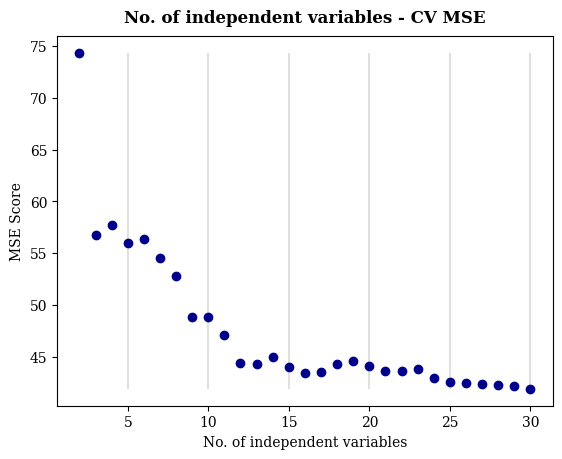

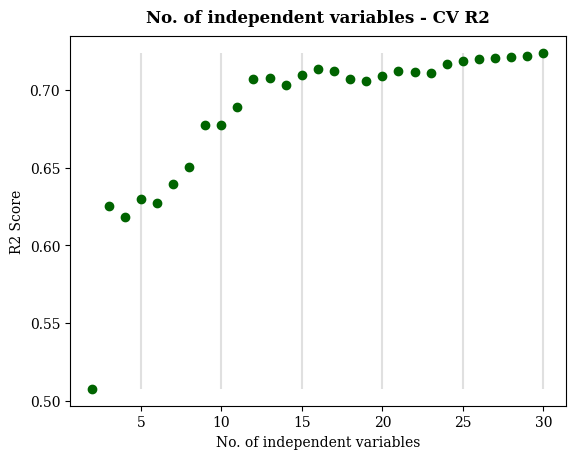

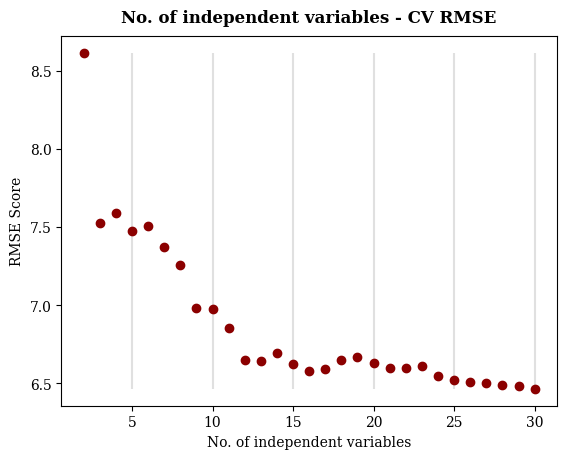

In [ ]:
import matplotlib.pyplot as plt

a=0
b=0
c=0
d=0
while a < len(perfs_names):
    
    #define font
    plt.rcParams["font.family"] = "serif"
    
    x = Novar_performances["Novar"]
    y = Novar_performances[perfs_names[a]]
    fig, ax = plt.subplots()
    plt.title("No. of independent variables - "+  str(perfs[b]), fontweight='bold', pad=10)
    plt.xlabel("No. of independent variables")
    plt.ylabel(perfs_abvs[b] + " Score")
    
    plt.scatter(x, y, color = colors[d], zorder=10)
    ax.vlines([5, 10, 15, 20, 25, 30],min(y),max(y), linestyles='solid', colors='lightgrey', alpha=0.7, zorder=1)
    
    plt.savefig('Novars_' + str(perfs_names[a]) + '.jpg',bbox_inches='tight')
    a+=1
    b+=1
    c+=1
    d+=1
            
                

## Select dataset (no. vars) with best performance

In [ ]:
#define no. of predictors that corresponds with best model performance
i = 12 - 2 #(a - b) - a is equal to preferred no. of predictors.
print(novar2[i])

population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300$|BldDen100$|NDVI|road_class_2_25|trop_mean_filt_2019


In [ ]:
dataset_predicting = dataset_xy.filter(regex = 'population_3000|road_class_3_3000|trafBuf25|population_1000|nightlight_450|nightlight_3150|trafBuf50|road_class_3_300$|BldDen100$|NDVI|road_class_2_25|trop_mean_filt_2019|mean_value_NO2|Longitude|Latitude')

In [ ]:
dataset_predicting.head()

,Longitude,Latitude,mean_value_NO2,nightlight_450,nightlight_3150,population_1000,population_3000,road_class_2_25,road_class_3_3000,road_class_3_300,trop_mean_filt_2019,BldDen100,NDVI,trafBuf25,trafBuf50
0,10.008293,48.397079,29.250500,22.585377,13.402575,8123.319336,54316.64453,0.000000,203502.42190,4167.064941,0.000058,1.000663,2310.0,0.000000,0.000000
1,10.021227,53.523262,32.098936,23.546194,22.862799,9558.207031,76786.28125,0.000000,99596.04688,1850.278076,0.000081,0.978245,2518.0,0.000000,0.000000
2,10.053859,53.592301,58.703744,18.290140,16.493486,10471.541020,88439.60938,46.359188,265563.71880,2016.838379,0.000076,0.914638,3216.0,674.791667,674.791667
3,10.081685,53.529020,24.249276,23.645823,18.248226,11165.945310,76961.00000,0.000000,97921.56250,478.363281,0.000074,0.712983,1052.0,0.000000,0.000000
4,10.096292,48.847917,19.912116,14.026642,5.514785,6017.511230,30814.58984,0.000000,176265.68750,3338.221191,0.000047,1.000641,3240.0,0.000000,0.000000


## Export option

In [ ]:
dataset_predicting.to_csv('C:/Users/foeke/OneDrive/Documenten/submitting paper/All scripts - paper/data/GlobalModelData/PredictingDataset.csv')